# Workflow to analyze the rift catalog

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime as dt
%matplotlib inline
import matplotlib 
from netCDF4 import Dataset    

dataset_path = '/data/fast0/datasets/'

plt.style.use('fivethirtyeight')
# matplotlib.rcParams['ytick.labelsize'] = 'large'
# matplotlib.rcParams['xtick.labelsize'] = 'large'
# matplotlib.rcParams['axes.labelsize'] = 'large'


import numpy as np
import rasterio
from rasterio.plot import show
import pickle

from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer

import pandas as pd
import geopandas as gpd

from scipy import stats

In [2]:
# !pip3 install pickle5
import sys
print(sys.version)

3.9.2 (default, Mar 10 2021, 17:29:56) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


In [3]:
# (option, useful for Brunt / Halloween)
# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


## Load the GPS Data

In [4]:
# Load these now so that we can plot the GPS locations on the map
gps = pd.read_csv(dataset_path + 'bas_marsh_monthly_halloween.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

## Load ITS_LIVE velocities

In [5]:

# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]


# d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
d = Dataset(dataset_path + 'ANT_G0120_0000.nc', 'r')
# print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)





# Calculate strains

dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


## Plot the rifts on imagery 

Text(0, 0.5, 'Polar Stereo Y (m)')

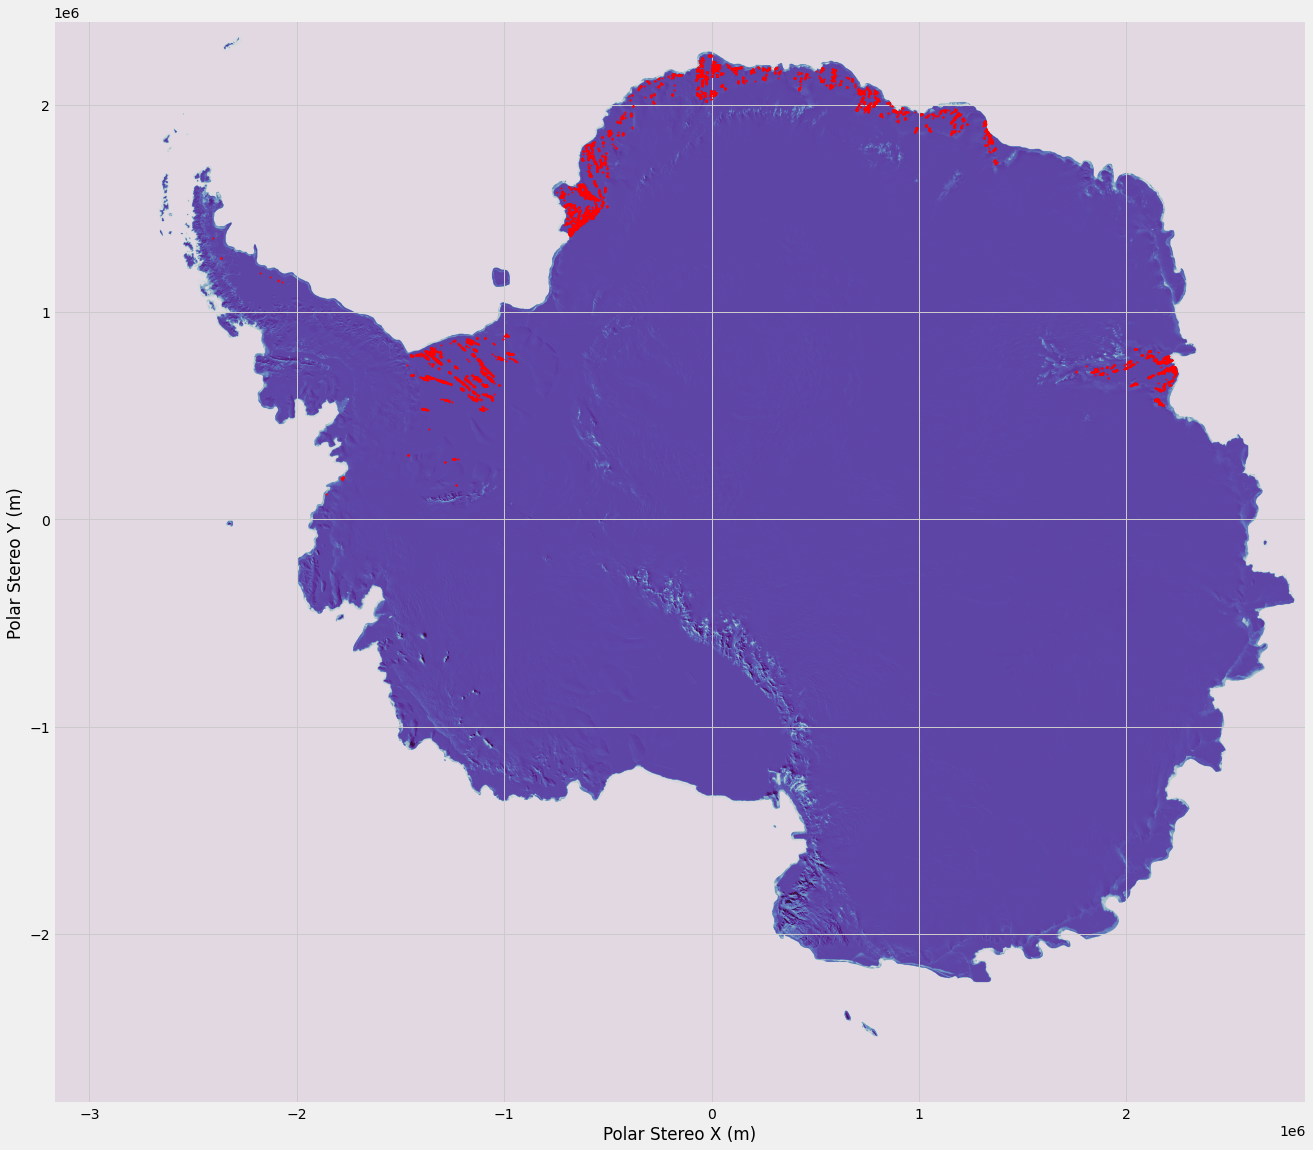

In [7]:
# image_file = 'datasets/riise_2020028_1615_modis_ch02.tif'
image_file = dataset_path + 'moa750_2014_hp1_v01.tif'

# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="twilight",ax=ax2)


# for shelf_name in ['amery','ross','brunt','Fimbul','Ronne','East','Amundsen']:
for shelf_name in ['amery','brunt','ap','fimbul']:

    # Load the rift observations
    rift_obs_output_file_name = 'rift_obs/' + shelf_name + '.pkl'
    with open(rift_obs_output_file_name, 'rb') as handle:
        rift_obs = pickle.load(handle)
    ax2.scatter(rift_obs['x-centroid'] ,rift_obs['y-centroid'] ,s=2,c='r')

    
with open('rift_obs/brunt.pkl', 'rb') as handle:
    rift_obs = pickle.load(handle)    

# Make a geopanda

rift_obs = gpd.GeoDataFrame(
    rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))



plt.xlabel('Polar Stereo X (m)')
plt.ylabel('Polar Stereo Y (m)')

In [8]:
rift_obs

,x-centroid,y-centroid,width,time,rgt,azimuth,sigma,h,beam,data_row,lat,lon,geometry
0,-670762.680523,1.383712e+06,19.657857,2018-10-16 17:43:10.150777+00:00,276.0,-9.125984,0.451114,2.992879,3r,3,-25.862067,-75.915839,POINT (-670762.681 1383711.898)
1,-671056.945058,1.384130e+06,19.657964,2018-10-16 17:43:10.150777+00:00,276.0,-9.123652,0.082928,4.453720,3r,3,-25.865141,-75.911263,POINT (-671056.945 1384129.794)
2,-671107.943454,1.384202e+06,39.316120,2018-10-16 17:43:10.150777+00:00,276.0,-9.123249,0.288615,3.150521,3r,3,-25.865675,-75.910471,POINT (-671107.943 1384202.075)
3,-671402.639096,1.384620e+06,39.086383,2018-10-16 17:43:10.150777+00:00,276.0,-9.120922,0.300812,2.883106,3r,3,-25.868768,-75.905898,POINT (-671402.639 1384619.533)
4,-671442.432018,1.384676e+06,19.658338,2018-10-16 17:43:10.150777+00:00,276.0,-9.120607,0.426359,4.032518,3r,3,-25.869187,-75.905281,POINT (-671442.432 1384675.803)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5317,-573310.362954,1.803480e+06,19.812848,2021-02-19 00:09:33.925158+00:00,870.0,-7.833105,0.079134,3.485558,3r,2164,-17.635000,-72.709991,POINT (-573310.363 1803480.142)
5318,-573711.730966,1.804320e+06,19.813289,2021-02-19 00:09:33.925158+00:00,870.0,-7.830497,0.024674,4.867636,3r,2164,-17.638871,-72.701686,POINT (-573711.731 1804320.418)
5319,-573951.129653,1.804821e+06,99.067811,2021-02-19 00:09:33.925158+00:00,870.0,-7.828943,0.044210,4.216168,3r,2164,-17.641186,-72.696738,POINT (-573951.130 1804820.882)
5320,-575620.376772,1.808306e+06,931.324511,2021-02-19 00:09:33.925158+00:00,870.0,-7.818156,0.010705,0.902781,3r,2164,-17.657329,-72.662286,POINT (-575620.377 1808305.530)


## Plot just the Halloween crack  against the ITS_LIVE velocities

<ipython-input-12-a6eee03757a8>:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',MarkerSize=20)
<ipython-input-12-a6eee03757a8>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',MarkerSize=20)
<ipython-input-12-a6eee03757a8>:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',MarkerSize=20)
<ipython-input-12-a6eee03757a8>:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)


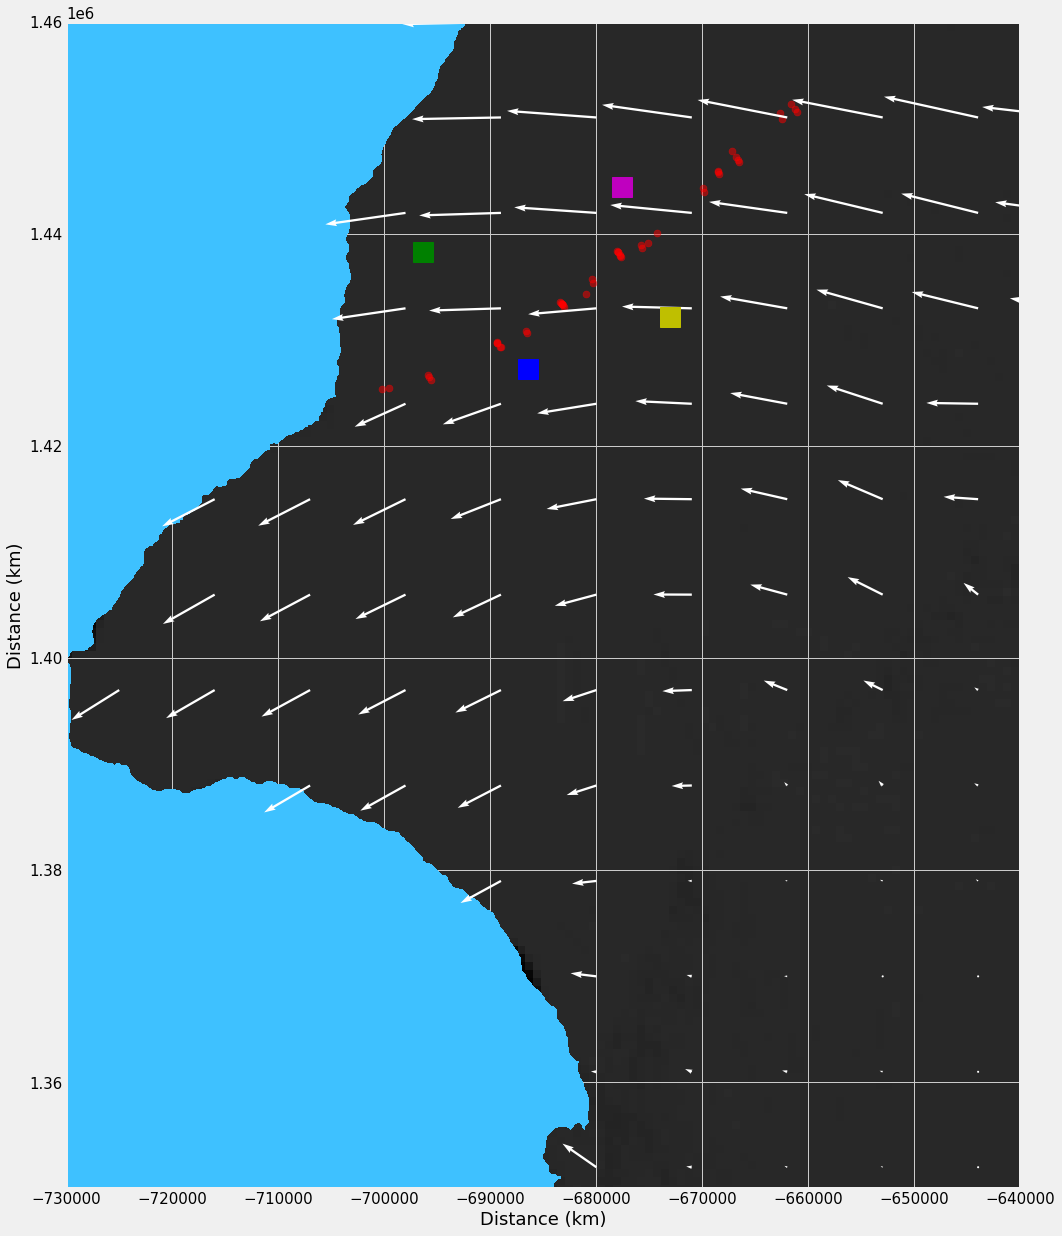

In [12]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]


fig3,ax3=plt.subplots(figsize=(20,20))

# Subset the data to the Halloween Crack polygon
ho = rift_obs[rift_obs.within(poly)]
with open('halloween.pickle', 'wb') as handle:
    pickle.dump(ho, handle, protocol=pickle.HIGHEST_PROTOCOL)

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))

image_file = dataset_path + 'moa125_2014_hp1_v01.tif'
# sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax3,vmin=0,vmax=1e5)

c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',MarkerSize=20)
plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',MarkerSize=20)
plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',MarkerSize=20)
plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
# plt.plot(box_x,box_y)
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [13]:

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( 'halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)
ho

/home/bpl7/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,x-centroid,y-centroid,width,time,rgt,azimuth,sigma,h,beam,data_row,lat,lon,geometry,rift-angle,rift-angle-xy,actual-width
11,-700179.554487,1.425371e+06,137.746336,2018-10-16 17:43:10.150777+00:00,276.0,-8.901646,0.070592,1.456827,3r,3,-26.161474,-75.459428,POINT (-700179.554 1425371.323),97.085291,97.085291,132.418930
67,-675100.223534,1.439150e+06,275.504567,2018-11-10 16:27:49.994267+00:00,657.0,-8.891313,0.082827,-0.064964,3r,55,-25.131109,-75.445232,POINT (-675100.224 1439149.992),77.915449,77.915449,275.076803
78,-675776.919864,1.438914e+06,39.358944,2018-11-15 03:12:21.336990+00:00,725.0,-171.091568,0.086524,2.786277,3r,65,-25.156803,-75.444563,POINT (-675776.920 1438913.916),77.915449,77.915449,36.746467
79,-675706.115956,1.438668e+06,236.152247,2018-11-15 03:12:21.336990+00:00,725.0,-171.090485,0.065238,2.340374,3r,65,-25.158260,-75.446852,POINT (-675706.116 1438668.077),77.915449,77.915449,220.475880
115,-686499.283759,1.430681e+06,157.422192,2018-12-13 14:55:15.840583+00:00,1160.0,-8.916196,0.107148,-0.589053,3r,131,-25.633601,-75.470292,POINT (-686499.284 1430680.756),87.621070,87.621070,156.398636
116,-686622.452909,1.430859e+06,157.421652,2018-12-13 14:55:15.840583+00:00,1160.0,-8.915360,0.121400,-0.839401,3r,131,-25.634830,-75.468355,POINT (-686622.453 1430858.750),87.621070,87.621070,156.398360
120,-669916.485880,1.444310e+06,19.680558,2018-12-14 01:48:05.538331+00:00,1167.0,-171.087311,0.061215,4.163218,3r,133,-24.883349,-75.422711,POINT (-669916.486 1444310.433),78.036282,78.036282,18.388555
121,-669820.224852,1.443970e+06,216.485162,2018-12-14 01:48:05.538331+00:00,1167.0,-171.085815,0.041575,1.660817,3r,133,-24.885370,-75.425880,POINT (-669820.225 1443969.516),78.036282,78.036282,202.271177
195,-666505.206239,1.446757e+06,157.430791,2019-01-07 13:39:44.483041+00:00,154.0,-8.907515,0.078486,-0.710971,3r,196,-24.735014,-75.415560,POINT (-666505.206 1446756.719),75.363764,75.363764,156.644528
543,-683139.980859,1.433265e+06,491.918432,2019-04-12 09:11:15.279099+00:00,215.0,-8.897927,0.031737,0.758371,3r,433,-25.483960,-75.462297,POINT (-683139.981 1433265.239),75.867644,75.867644,489.867014


## Perform advection correction
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough


In [14]:
time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for i,t in enumerate(time_vector):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y'])
        vy_new = vy_interp(state_vector['x'],state_vector['y'])
        
        # Calculate strain rates
        e11 =  vx_x(state_vector['x'],state_vector['y']) 
        e12 = (  vx_y(state_vector['x'],state_vector['y']) 
              +  vy_x(state_vector['x'],state_vector['y']) ) / 2
        e22 =  vy_y(state_vector['x'],state_vector['y']) 
        
        if state_vector['x'].size > 1:
            vx_new = np.diag( vx_new )
            vy_new = np.diag( vy_new )
            e11 = np.diag ( e11 )
            e12 = np.diag ( e12 )
            e22 = np.diag ( e22 )
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a","h"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

0. Found 1 new observations at time 2018-10-16 17:43:10.150777+00:00 with dt=inf
1. Found 1 new observations at time 2018-11-10 16:27:49.994267+00:00 with dt=0.0683030345618805
2. Found 2 new observations at time 2018-11-15 03:12:21.336990+00:00 with dt=0.012176824052621238
3. Found 2 new observations at time 2018-12-13 14:55:15.840583+00:00 with dt=0.0779962514130669
4. Found 2 new observations at time 2018-12-14 01:48:05.538331+00:00 with dt=0.001241212821887596
5. Found 1 new observations at time 2019-01-07 13:39:44.483041+00:00 with dt=0.06706146680070728
6. Found 1 new observations at time 2019-04-12 09:11:15.279099+00:00 with dt=0.25958535490842144
7. Found 1 new observations at time 2019-04-20 19:47:24.212345+00:00 with dt=0.02311230680552387
8. Found 1 new observations at time 2019-05-07 07:55:33.956220+00:00 with dt=0.045190057034597046
9. Found 1 new observations at time 2019-05-15 07:38:52.934951+00:00 with dt=0.02187108584718103
10. Found 1 new observations at time 2019-05-

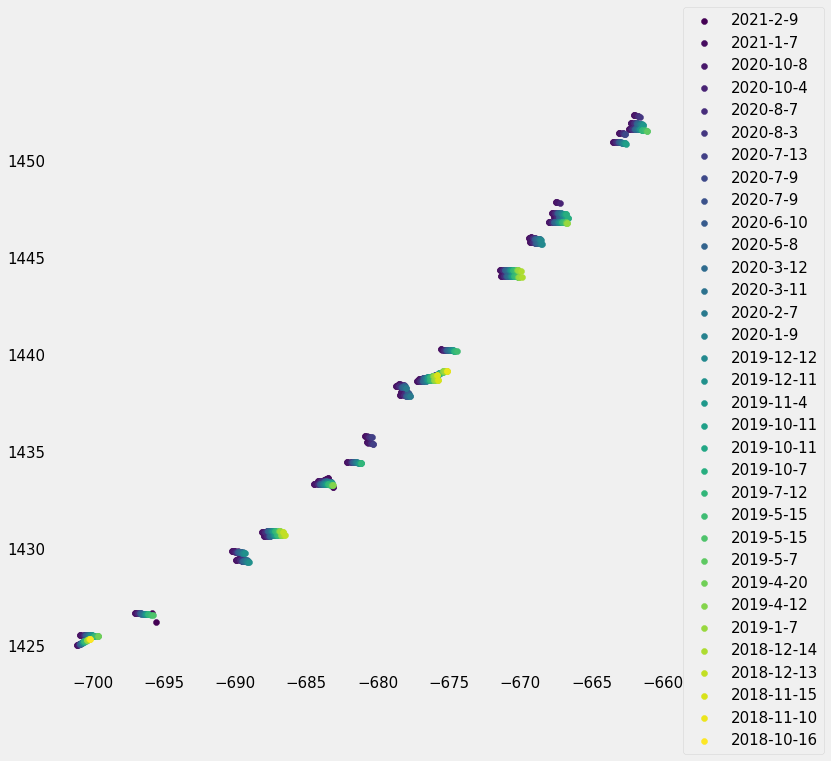

In [15]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
# plt.xlim((-694,-691))
# plt.ylim((1426,1429))
plt.show()

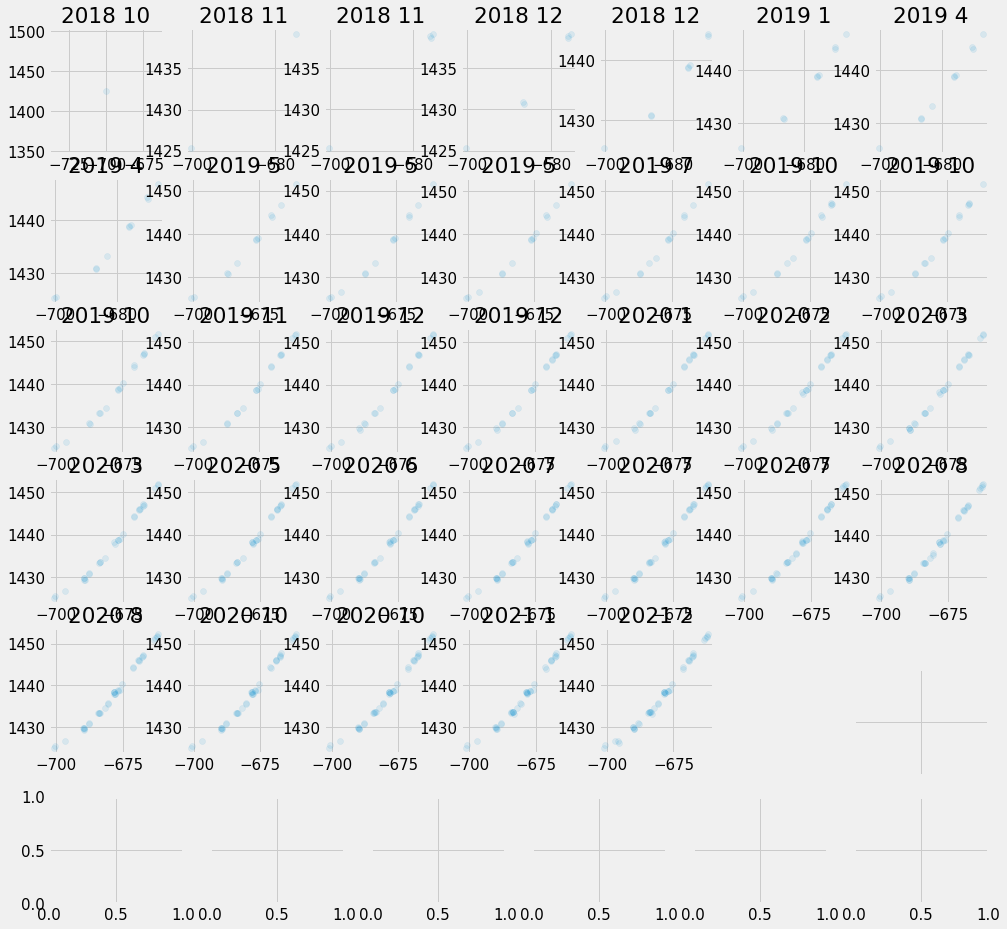

In [16]:
fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))
# fig9,ax9 = plt.subplots(7, 6,figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(6,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
    plt.title('%d %d'%(t.year,t.month))
plt.show()

In [17]:
latest = list_of_state_vectors[-1]
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
times_h = ho['time'].apply(lambda x: (x- latest.iloc[0]['t']).days).values

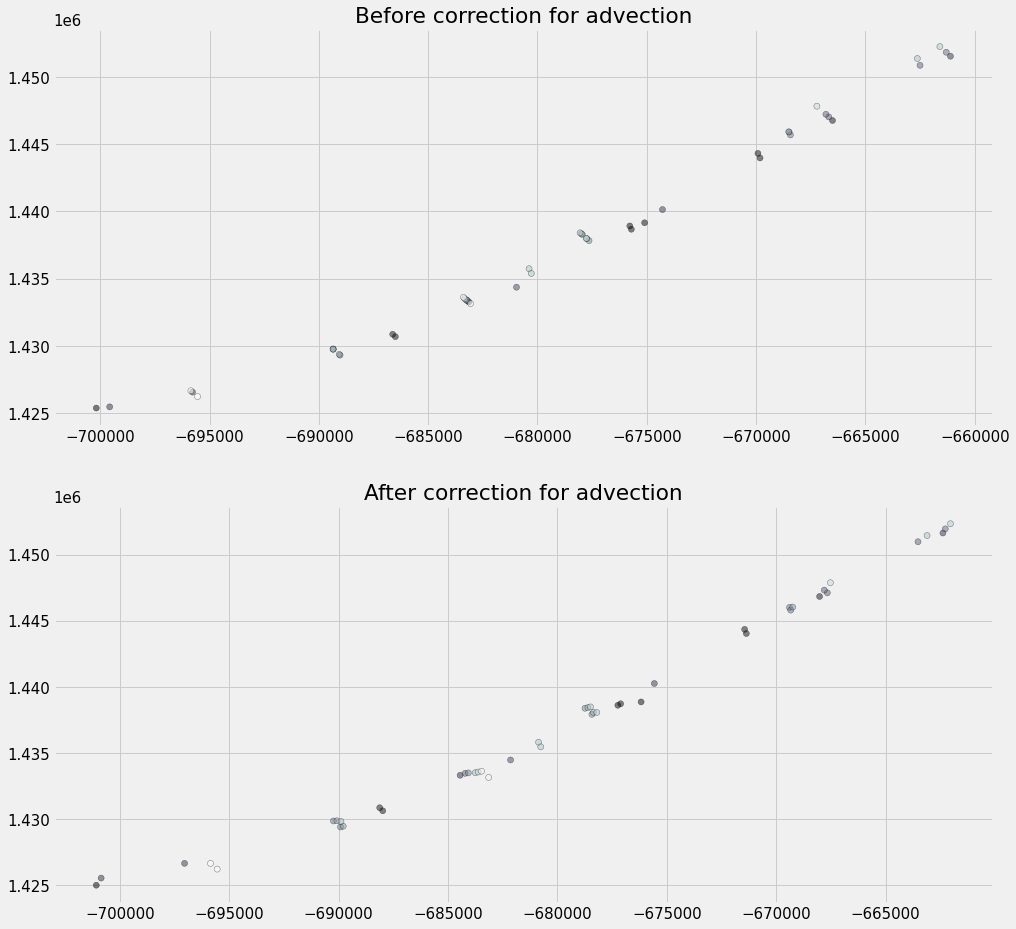

In [18]:
# Plot a snapshot
plt.subplots(2,1,figsize=(15,15))
ax=plt.subplot(2,1,1)
c=ax.scatter(ho['x-centroid'],ho['y-centroid'],c=times_h,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('Before correction for advection')

ax=plt.subplot(2,1,2)
c=ax.scatter(latest['x'],latest['y'],c=times,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('After correction for advection')
plt.show()

## Simple Model of Rift Opening

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


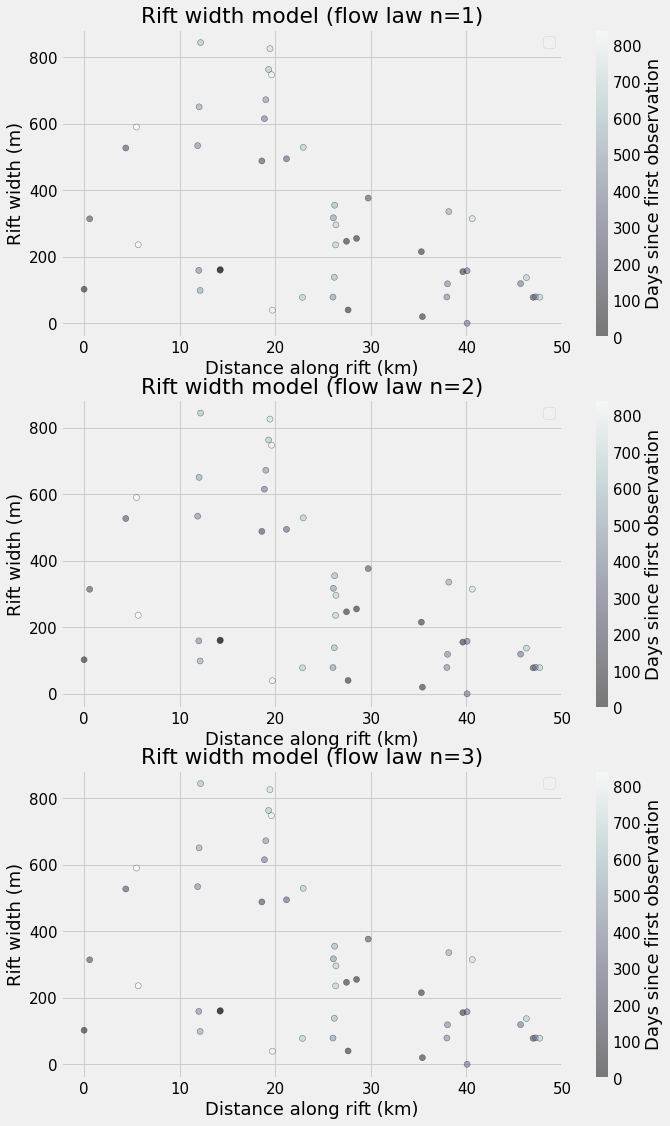

Stretching: 764.876712 m over 846.000000 days or 330.000000 m/y
Erosion + stretching: 900.000000 m over 846.000000 days or 388.297872 m/y
Erosion is 15.013699 %


In [30]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 48
xx = np.arange(0,rift_len,0.01)

tmax = max(times)
rate = 330 / 365
wmax = rate * tmax

wmax2 = 900
rate2 = wmax2/tmax
r = np.sqrt(rift_len**2 - xx**2)





fig12 = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)


for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
#     ax.plot(xx,wmax* (r/rift_len)**n,'-',label='Just stretching')
#     ax.plot(xx,wmax2* (r/rift_len)**n,'-',label='Stretch + Erosion')
    ax.legend()

    c=ax.scatter(dist/1e3,latest['w'],c=times,cmap='bone',label=latest['t'],\
                 alpha=0.5,edgecolors='k')
    cbar=plt.colorbar(c)

    cbar.set_label('Days since first observation')
    ax.set_xlabel('Distance along rift (km)')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)



plt.show()

print('Stretching: %f m over %f days or %f m/y'%(wmax,tmax,rate * 365))
print('Erosion + stretching: %f m over %f days or %f m/y'%(wmax2,tmax,rate2 * 365))
print('Erosion is %f %%'%(100*(wmax2-wmax)/wmax2))

## Calculate the average GPS opening

In [20]:
t = gps.YYYY.values + gps.MM.values / 12
hh00_vx = stats.linregress(t[0:len(hh00_x)], hh00_x).slope
hh00_vy = stats.linregress(t[0:len(hh00_y)], hh00_y).slope
tt05_vx = stats.linregress(t[0:len(tt05_x)], tt05_x).slope
tt05_vy = stats.linregress(t[0:len(tt05_y)], tt05_y).slope
ss00_vx = stats.linregress(t[0:len(ss00_x)], ss00_x).slope
ss00_vy = stats.linregress(t[0:len(ss00_y)], ss00_y).slope
tt04_vx = stats.linregress(t[0:len(tt04_x)], tt04_x).slope
tt04_vy = stats.linregress(t[0:len(tt04_y)], tt04_y).slope

#What is the average strike of the rift?
res = stats.linregress(latest['x'], latest['y'])
theta = - np.arctan(res.slope) 
rot = np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta), np.cos(theta)]])

hh00_v = np.array([hh00_vx, hh00_vy])
tt05_v = np.array([tt05_vx, tt05_vy])
ss00_v = np.array([ss00_vx, ss00_vy])
tt04_v = np.array([tt04_vx, tt04_vy])

#
# Rotate into rift-coordinates
#

v1 = np.dot(rot, hh00_v)
v2 = np.dot(rot, tt05_v)
v3 = np.dot(rot, ss00_v)
v4 = np.dot(rot, tt04_v)

relative_motion = v1-v2


print('Relative motion with just hh00 and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])
print(' ')
relative_motion = (v1+v3)/2-(v2+v4)/2
print('Relative motion with hh00, ss00, tt04, and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])

Relative motion with just hh00 and tt05:
   Rift Shearing: -190.848147 m/a 
   Rift Opening: 338.490526 m/a 
 
Relative motion with hh00, ss00, tt04, and tt05:
   Rift Shearing: -167.295864 m/a 
   Rift Opening: 349.291939 m/a 


## Use GPS to calculate the time-dependent extension and shearing

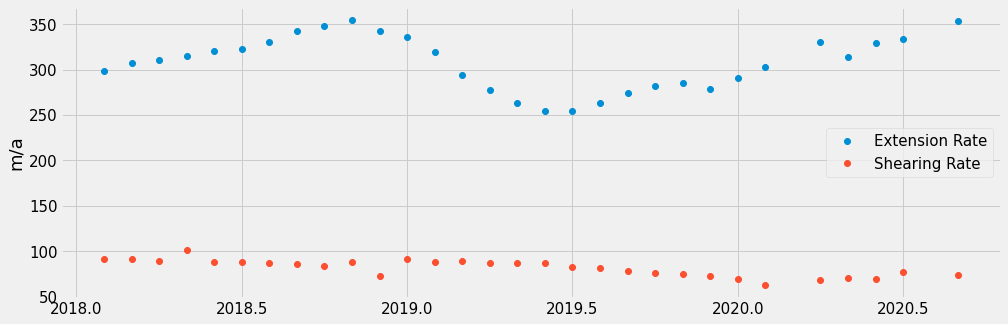

-81.89294858743874
307.53083839760745


In [21]:
# What do the GPS data look like?

t = gps.YYYY.values + gps.MM.values / 12
hh00_u = np.array(gps.PSU[ gps.Site=='HH00' ])
hh00_v = np.array(gps.PSV[ gps.Site=='HH00' ])
tt05_u = np.array(gps.PSU[ gps.Site=='TT05' ])
tt05_v = np.array(gps.PSV[ gps.Site=='TT05' ])
ss00_u = np.array(gps.PSU[ gps.Site=='SS00' ])
ss00_v = np.array(gps.PSV[ gps.Site=='SS00' ])
tt04_u = np.array(gps.PSU[ gps.Site=='TT04' ])
tt04_v = np.array(gps.PSV[ gps.Site=='TT04' ])

#
# Rotate into rift-coordinates
#


v1 = np.dot(rot, np.array([hh00_u,hh00_v])[:,0:30])
v2 = np.dot(rot, np.array([tt05_u,tt05_v])[:,0:30])
v3 = np.dot(rot, np.array([ss00_u,ss00_v])[:,0:30])
v4 = np.dot(rot, np.array([tt04_u,tt04_v])[:,0:30])

# relative_motion = (v1+v3)/2-(v2+v4)/2
relative_motion = (v1-v2)*365

plt.subplots(figsize=(15,5))
plt.plot(t[0:30],relative_motion[1,:],'o',label='Extension Rate')
plt.plot(t[0:30],-relative_motion[0,:],'o',label='Shearing Rate')
plt.legend()
plt.ylabel('m/a')

plt.show()

print(np.mean(relative_motion[0,:]))
print(np.mean(relative_motion[1,:]))

## Can we observe this the variability in stretching rate in the ICESat-2 data?

In [ ]:
plt.subplots(figsize=(15,5))
plt.scatter(latest['t'],latest['w'],c=dist)

In [70]:
e11 

array([[-0.07660235, -0.00127265],
       [-0.00909985,  0.02740535]])

## Does the melange thicken with time?

Text(0, 0.5, 'Melange Thickness (m)')

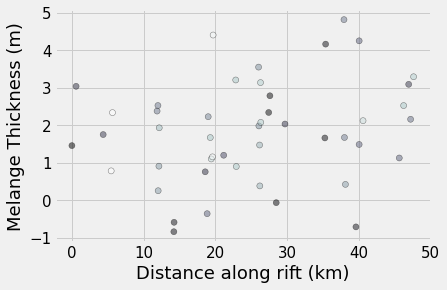

In [31]:
plt.subplots()
plt.scatter(dist/1e3,latest['h'],c=times,cmap='bone',label=latest['t'],\
                 alpha=0.5,edgecolors='k')
plt.xlabel('Distance along rift (km)')
plt.ylabel('Melange Thickness (m)')

Text(0, 0.5, 'Melange Thickness (m)')

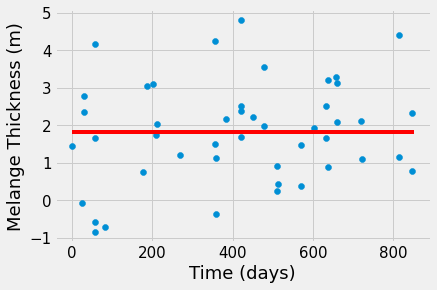

In [35]:
plt.scatter(times,latest['h'])
plt.plot((0,850),np.mean(latest['h'])*np.array((1,1)),'-r')
plt.xlabel('Time (days)')
plt.ylabel('Melange Thickness (m)')